### Regression Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

matrix = pd.read_csv('../Data/feature_matrix.csv', index_col = 0)

Text(0.5, 1.0, 'Correlation Matrix')

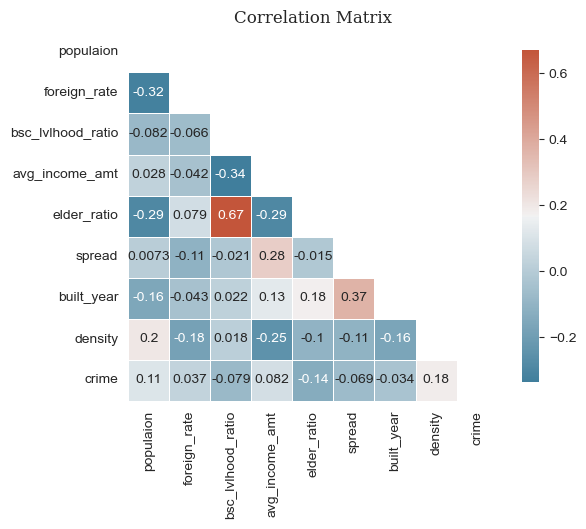

In [2]:
import seaborn as sns
from matplotlib import font_manager, rc

mask = np.triu(np.ones_like(matrix.iloc[:,:-1].corr(), dtype = bool))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
plt.grid(False)
sns.heatmap(matrix.iloc[:,:-1].corr(), mask = mask, cmap = cmap,
            square = True, linewidths = .5, cbar_kws = {"shrink": .9}, annot = True)
plt.title('Correlation Matrix', fontsize = 12, fontfamily = 'Serif')

In [3]:
matrix.dropna(inplace = True)

#### Randomforest Regression

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

matrix = matrix.astype('float')
X_train, X_test, y_train, y_test = train_test_split(matrix.iloc[:,:-1].drop('spread', axis = 1), 
                                                    matrix['spread'], 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [5]:
rf_regressor = RandomForestRegressor(n_estimators = 1000, 
                                     random_state = 42,
                                     criterion = 'squared_error',
                                     ccp_alpha = 0.0005,
                                     max_depth = 5,
                                     max_leaf_nodes = 3)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=0.0005, max_depth=5, max_leaf_nodes=3,
                      n_estimators=1000, random_state=42)

In [6]:
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.012826050813322257


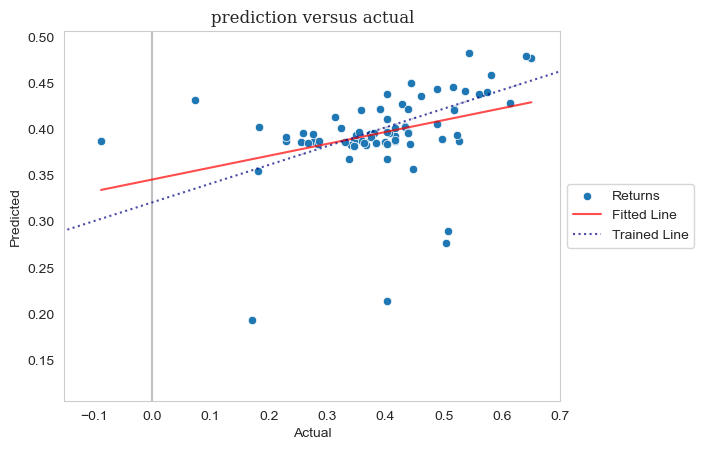

In [7]:
import seaborn as sns

beta, alpha = np.polyfit(x = y_test, y = y_pred , deg = 1)
beta_1, alpha_1 = np.polyfit(x = y_train, y = rf_regressor.predict(X_train) , deg = 1)
plt.axvline(0, color = 'grey', alpha = 0.5)

sns.scatterplot(x = y_test , y = y_pred , label = 'Returns')
sns.lineplot(x = y_test, y = alpha + y_test * beta, color = 'red', label = 'Fitted Line', alpha = 0.7)
sns.lineplot(x = y_train, y = alpha_1 + y_train * beta_1, color = 'navy', label = 'Trained Line', alpha = 0.7, ls = ':')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid(False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('prediction versus actual', fontfamily = 'Serif')
plt.xlim([-0.15,0.7])
plt.show()

In [8]:
X_train

,populaion,foreign_rate,bsc_lvlhood_ratio,avg_income_amt,elder_ratio,built_year,density,crime
광진구군자동,21530.0,0.104041,0.080882,8.604438,0.169063,15.886497,29086.0,0.82
강북구번3동,16514.0,0.004057,0.373806,8.199766,0.301065,21.916188,14954.0,0.20
중구동화동,10188.0,0.016981,0.054441,8.319652,0.205224,17.956979,39227.0,0.30
동대문구장안1동,38402.0,0.016640,0.088087,8.270832,0.187738,12.163880,30942.0,0.72
영등포구양평2동,22702.0,0.009074,0.025234,8.402487,0.123723,14.912274,7528.0,0.28
...,...,...,...,...,...,...,...,...
광진구능동,11564.0,0.033898,0.059279,8.852623,0.154393,9.758607,10510.0,0.82
중랑구신내2동,19975.0,0.004055,0.160966,8.252652,0.226094,19.735779,21672.0,0.62
구로구오류1동,23312.0,0.027926,0.086651,8.227033,0.189662,18.021969,39197.0,0.70
서초구반포4동,19464.0,0.037145,0.016546,9.343650,0.166487,14.751870,13627.0,0.80


In [19]:
import shap

X_train, X_test, y_train, y_test = train_test_split(matrix.iloc[:,:-1].drop('spread', axis = 1), 
                                                    matrix['spread'], 
                                                    test_size = 0.2, 
                                                    random_state = 42)

explainer_randomforest_reg = shap.TreeExplainer(rf_regressor)

In [20]:
shap_values_train = explainer_randomforest_reg(X_train, check_additivity=False)
shap_values_test = explainer_randomforest_reg(X_test, check_additivity=False)
shap_values_all = explainer_randomforest_reg(matrix.iloc[:,:-1].drop('spread', axis = 1), check_additivity=False)

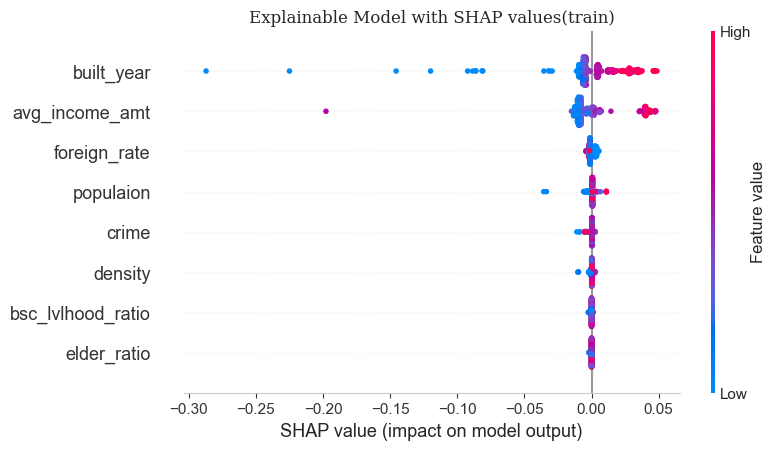

In [25]:
plt.grid(False)
plt.title('Explainable Model with SHAP values(train)', fontsize = 12, fontfamily = 'Serif')
shap.plots.beeswarm(shap_values_train)
plt.show()

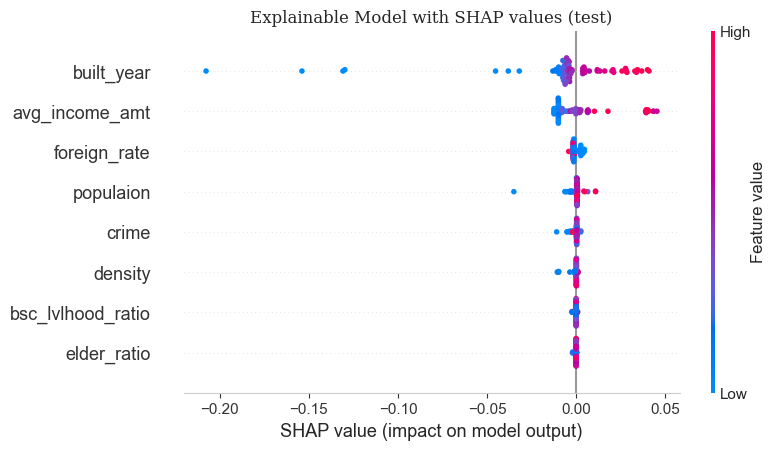

In [26]:
plt.grid(False)
plt.title('Explainable Model with SHAP values (test)', fontsize = 12, fontfamily = 'Serif')
shap.plots.beeswarm(shap_values_test)
plt.show()

#### Double Machine Learning

built year와 avg income amount는 treatment effect가 얼마나 클까?

In [31]:
matrix['spread'].head() # target

종로구사직동    0.402121
종로구삼청동    0.402121
종로구부암동   -0.416352
종로구평창동    0.341060
종로구무악동    0.289968
Name: spread, dtype: float64

In [32]:
matrix['avg_income_amt'].head() # treatment

종로구사직동    8.753692
종로구삼청동    8.612424
종로구부암동    8.567173
종로구평창동    9.026260
종로구무악동    8.381916
Name: avg_income_amt, dtype: float64

In [33]:
from econml.dml import LinearDML
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

Average Income Amount

In [51]:
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(matrix.iloc[:,:-1].drop(['spread','avg_income_amt'], axis = 1),  
                                                                     matrix['avg_income_amt'], 
                                                                     matrix['spread'], 
                                                                     test_size = 0.3, 
                                                                     random_state = 42)

dml_model = LinearDML(model_y = Ridge(), 
                      model_t = Ridge(), 
                      random_state = 42)

dml_model.fit(Y = y_train, 
              T = T_train, 
              X = X_train)

treatment_effect = dml_model.effect(X_train)

print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: 0.12406796090772634


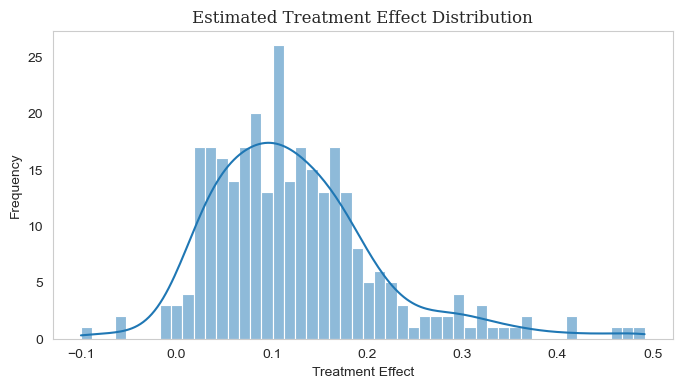

In [52]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50)
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

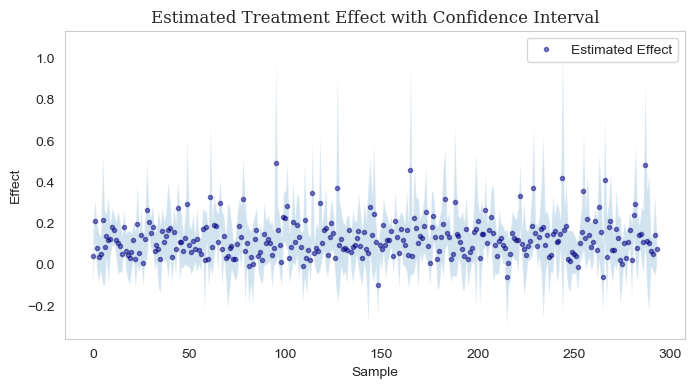

In [58]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_train)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_train)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2)
plt.scatter(range(len(X_train)), treatment_effect, label='Estimated Effect', marker = '.', color = 'navy', alpha = 0.5)
plt.title('Estimated Treatment Effect with Confidence Interval', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

Built Year

In [66]:
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(matrix.iloc[:,:-1].drop(['spread','built_year'], axis = 1),  
                                                                     matrix['built_year'], 
                                                                     matrix['spread'], 
                                                                     test_size = 0.3, 
                                                                     random_state = 42)

dml_model = LinearDML(model_y = Ridge(), 
                      model_t = Ridge(), 
                      random_state = 42)

dml_model.fit(Y = y_train, 
              T = T_train, 
              X = X_train)

treatment_effect = dml_model.effect(X_train)

print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: 0.009716019023523464


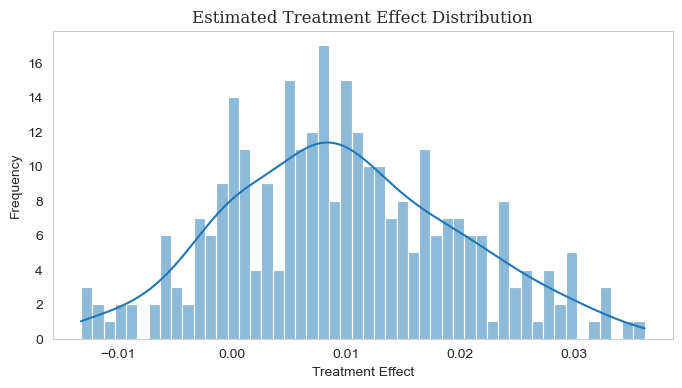

In [67]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50)
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

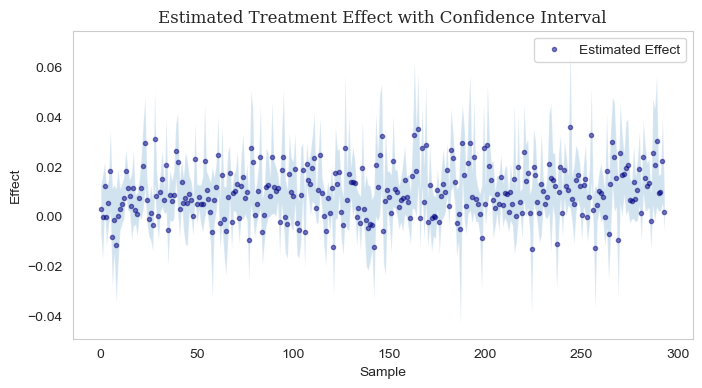

In [68]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_train)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_train)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2)
plt.scatter(range(len(X_train)), treatment_effect, label='Estimated Effect', marker = '.', color = 'navy', alpha = 0.5)
plt.title('Estimated Treatment Effect with Confidence Interval', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

결론 : 평균소득은 실제로 spread에 유의미한 영향을 미치지만, spread 추정에 있어서 built year는 예측에 좋은 변수이지, 인과관계가 있다고 보기에는 힘들다